# Monte Carlo Dispersion Analysis with the Dispersion Class

Finally the Monte Carlo Simulations can be performed using a dedicated class called Dispersion. This class is a wrapper for the Monte Carlo Simulations, and it is the recommended way to perform the simulations. Say goodbye to the long and tedious process of creating the Monte Carlo Simulations throughout jupyter notebooks!

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, let's import the necessary libraries, including the newest Dispersion class!

In [4]:
from rocketpy import Environment, Rocket, SolidMotor, Flight, Dispersion


If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.

In [5]:
%matplotlib inline

The Dispersion class allows us to perform Monte Carlo Simulations in a very simple way.
We just need to create an instance of the class, and then call the method run() to perform the simulations.
The class has a lot of capabilities, but we will only use a few of them in this example.
We encourage you to check the documentation of the class to learn more about the Dispersion.

Also, you can check RocketPy's main reference for a better conceptual understanding 
of the Monte Carlo Simulations: [RocketPy: Six Degree-of-Freedom Rocket Trajectory Simulator](https://doi.org/10.1061/(ASCE)AS.1943-5525.0001331)

We will describe two different options of usage:
- Using a Flight object as input, speeding up the process of creating the simulations. (currently not completely described in this notebook)
- Using a dictionary as input, including mean values and uncertainties for each parameter 

You need only one of them to get started. 

## 1st Option -> Use your Flight object as input for the Dispersion class

### Creating an Environment for 'Ponte de Sôr', Portugal

In [6]:
Env = Environment(
    railLength=5.2, latitude=39.389700, longitude=-8.288964, elevation=113
)


To get weather data from the GFS forecast, available online, we run the following lines.

First, we set tomorrow's date.

In [7]:
import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

Env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time


Then, we tell Env to use a GFS forecast to get the atmospheric conditions for flight.

Don't mind the warning, it just means that not all variables, such as wind speed or atmospheric temperature, are available at all altitudes given by the forecast.

In [ ]:
# Env.setAtmosphericModel(type="Forecast", file="GFS")


Load an previous ran environment analysis as input for Environment

In [8]:
import json

file = open("../../../data/weather/EuroC_export_env_analysis.json")
env_dict = json.load(file)
file.close()


In [9]:
import numpy as np

hour = str(Env.date.hour)

pressure_profile = np.array(env_dict["atmosphericModelPressureProfile"][hour])
pressure_profile = np.column_stack(
    (pressure_profile[:, 0], 100 * pressure_profile[:, 1])
)
temperature_profile = np.array(env_dict["atmosphericModelTemperatureProfile"][hour])
temperature_profile = np.column_stack(
    (temperature_profile[:, 0], 273 + temperature_profile[:, 1])
)
wind_u = env_dict["atmosphericModelWindVelocityXProfile"][hour]
wind_v = env_dict["atmosphericModelWindVelocityYProfile"][hour]


In [10]:
Env.setAtmosphericModel(
    type="CustomAtmosphere",
    pressure=pressure_profile,
    temperature=temperature_profile,
    wind_u=wind_u,
    wind_v=wind_v,
)


Gravity Details

Acceleration of Gravity: 9.80665 m/s²


Launch Site Details

Launch Rail Length: 5.2  m
Launch Date: 2022-10-11 12:00:00 UTC
Launch Site Latitude: 39.38970°
Launch Site Longitude: -8.28896°
Launch Site Surface Elevation: 113.0 m


Atmospheric Model Details

Atmospheric Model Type: CustomAtmosphere
CustomAtmosphere Maximum Height: 13.884 km


Surface Atmospheric Conditions

Surface Wind Speed: 0.79 m/s
Surface Wind Direction: 175.73°
Surface Wind Heading: 355.73°
Surface Pressure: 992.00 hPa
Surface Temperature: 291.09 K
Surface Air Density: 1.187 kg/m³
Surface Speed of Sound: 342.02 m/s


Atmospheric Model Plots


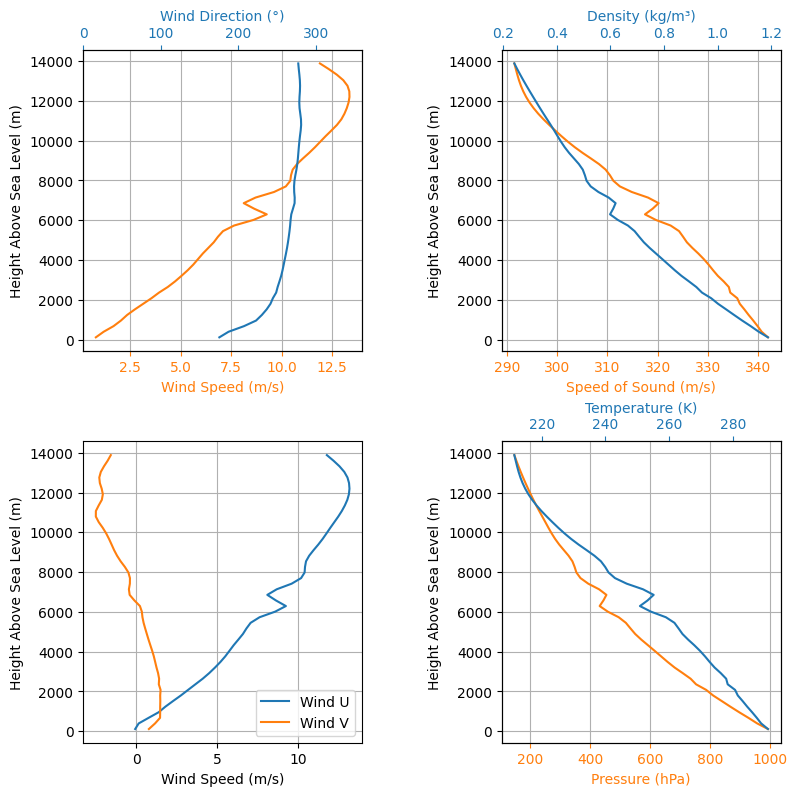

In [11]:
Env.allInfo()


### Creating a Motor for the Rocket

We define a motor for the rocket, using the data from the manufacturer, and following
the [RocketPy's documentation](https://docs.rocketpy.org/en/latest/user/index.html).

In [12]:
Pro75M1670 = SolidMotor(
    thrustSource="../../../data/motors/Cesaroni_M1670.eng",
    burnOut=3.9,
    grainNumber=5,
    grainSeparation=5 / 1000,
    grainDensity=1815,
    grainOuterRadius=33 / 1000,
    grainInitialInnerRadius=15 / 1000,
    grainInitialHeight=120 / 1000,
    nozzleRadius=33 / 1000,
    throatRadius=11 / 1000,
    interpolationMethod="linear",
)



Motor Details
Total Burning Time: 3.9 s
Total Propellant Mass: 2.956 kg
Propellant Exhaust Velocity: 2038.745 m/s
Average Thrust: 1545.218 N
Maximum Thrust: 2200.0 N at 0.15 s after ignition.
Total Impulse: 6026.350 Ns

Plots


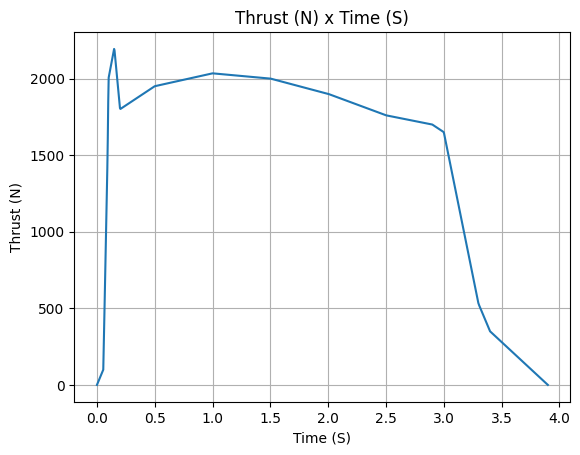

In [13]:
Pro75M1670.info()


### Creating a Rocket

In [31]:
Calisto = Rocket(
    motor=Pro75M1670,
    radius=127 / 2000,
    mass=19.197 - 2.956,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="../../../data/calisto/powerOffDragCurve.csv",
    powerOnDrag="../../../data/calisto/powerOnDragCurve.csv",
)

Calisto.setRailButtons([0.2, -0.5])

NoseCone = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)

FinSet = Calisto.addFins(
    4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
)

Tail = Calisto.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)


Additionally, we set parachutes for our Rocket, as well as the trigger functions for the deployment of such parachutes.

In [32]:
def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False


def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 + 1400 m (+1400 due to surface elevation).
    return True if y[5] < 0 and y[2] < 800 + 1400 else False


Main = Calisto.addParachute(
    "Main",
    CdS=10.0,
    trigger=mainTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = Calisto.addParachute(
    "Drogue",
    CdS=1.0,
    trigger=drogueTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)


Inertia Details
Rocket Dry Mass: 16.241 kg (No Propellant)
Rocket Total Mass: 19.196911961392022 kg (With Propellant)

Geometrical Parameters
Rocket Radius: 0.0635 m

Aerodynamics Stability
Initial Static Margin: 2.051 c
Final Static Margin: 3.090 c

Main Parachute
CdS Coefficient: 10.0 m2

Drogue Parachute
CdS Coefficient: 1.0 m2

Aerodynamics Plots


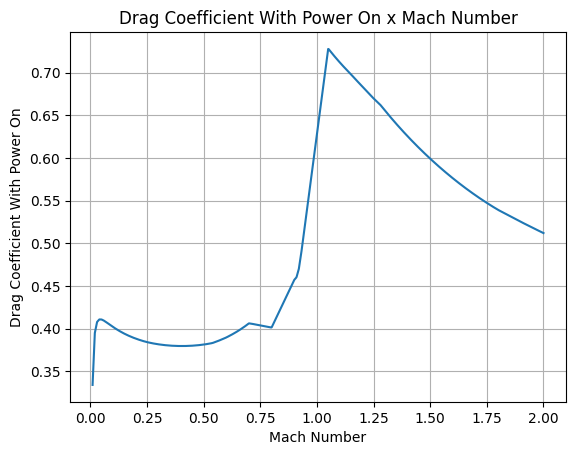

In [16]:
Calisto.info()


### Simulate single flight

In [17]:
TestFlight = Flight(
    rocket=Calisto,
    environment=Env,
    inclination=84,
    heading=133,
)


And we can visualize the flight trajectory:

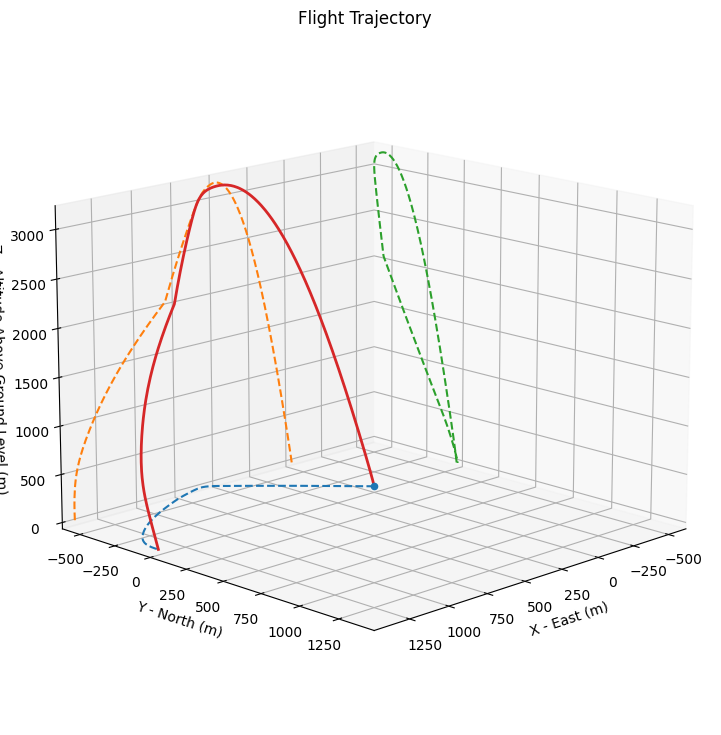

In [18]:
TestFlight.plot3dTrajectory()


Export Flight Trajectory to a .kml file so it can be opened on Google Earth

In [19]:
TestFlight.exportKML(
    fileName="trajectory.kml",
    timeStep=None,
    extrude=True,
    color="641400F0",
    altitudeMode="relativetoground",
)


[[0.00000000e+00 1.33000000e+02]
 [1.41076548e-03 1.33000000e+02]
 [2.82153096e-03 1.33000000e+02]
 ...
 [4.61443985e+02 8.97087177e+01]
 [4.62487459e+02 8.96739146e+01]
 [4.63526604e+02 8.96399417e+01]]
File  trajectory.kml  saved with success!


### Starting the Monte Carlo Simulations

First, let's invoke the Dispersion class, we only need a filename to initialize it.
The filename will be used either to save the results of the simulations or to load them
from a previous ran simulation.

In [39]:
TestDispersion = Dispersion(filename="dispersion_analysis_outputs/disp_class_example")


Then, we can run the simulations using the method Dispersion.run_dispersion().
But before that, we need to set some simple parameters for the simulations.
We will set them by using a dictionary, which is one of the simplest way to do it.

In [40]:
# TODO: This is work in progress, we need to understand how to setup simulations of such kind
disp_dict_model_1 = {
    # Environment Parameters
    "railLength": 0.001,
    # "date": ,
    # "datum": ["WSG84"],
    "elevation": 10,
    "gravity": 0,
    "latitude": 0,
    "longitude": 0,
    # "timeZone": [str(Env.timeZone)],
    # Solid Motor Parameters
    "burnOutTime": 0.2,
    "grainDensity": 0.1 * Pro75M1670.grainDensity,
    "grainInitialHeight": 0.001,
    "grainInitialInnerRadius": 0.001,
    "grainNumber": 0,
    "grainOuterRadius": 0.001,
    "grainSeparation": 0.001,
    "nozzleRadius": 0.001,
    "throatRadius": 0.001,
    # "thrustSource": ,
    "totalImpulse": 0.033 * Pro75M1670.totalImpulse,
    # Rocket Parameters
    "mass": 0.100,
    "radius": 0.001,
    "distanceRocketNozzle": 0.010,
    "distanceRocketPropellant": 0.010,
    "inertiaI": Calisto.inertiaI * 0.1,
    "inertiaZ": Calisto.inertiaZ * 0.1,
    "powerOffDrag": 0.033, # Multiplier
    "powerOnDrag": 0.033, # Multiplier
    # "noseKind": [Calisto.noseKind],
    "noseLength": 0.001,
    "noseDistanceToCM": 0.010,
    "numberOfFins": 0,
    "finRootChord": 0.001,
    "finTipChord": 0.001,
    "span": 0.001,
    "distanceToCM": 0.010,
    "finRadius": 0.001,
    # "finAirfoil": Calisto.finAirfoil,
    "tailTopRadius": 0.001,
    # "parachuteNames": ["Main", "Drogue"],
    "CdS": [2, 0.3],
    "inclination": 1,
    "heading": 2,
    # "trigger": [[mainTrigger], [drogueTrigger]],
    # "noseLength": (0.588, 1 / 1000),
    # Flight Parameters
    # 'atol': ,
    # 'initialSolution': "",
    # 'maxTime': "",
    # 'maxTimeStep': "",
    # 'minTimeStep': "",
    # 'rtol': "",
    # 'terminateOnApogee': "",
    # 'timeOvershoot': "",
    # 'verbose': "",
}

Finally, let's iterate over the simulations and export the data from each flight simulation!

In [42]:
TestDispersion.run_dispersion(
    number_of_simulations=5,  # Be careful with this number, it will take a while to run
    dispersion_dictionary=disp_dict_model_1,
    flight=TestFlight,
    environment=Env,
    # motor=None,
    # rocket=None,
    bg_image=None,
)


'Starting'

RocketPy separates the running of simulations from the importing of data.
This is done to allow the user to run simulations in parallel, if desired, and
to allow the user to import data from different sources.

Remember to specify a good name for your loaded data, so you can easily identify
and treat them later. 

In [ ]:
# dispersion_results = TestDispersion.import_results()


### Visualizing the results

Now we finally have the results of our Monte Carlo simulations loaded!
Let's play with them.

First, we can print numerical information regarding the results of the simulations.

In [ ]:
# TestDispersion.info()


Also, we can visualize histograms of such results

In [ ]:
# TestDispersion.allInfo()


## 2nd Option -> Running by using only a dictionary of parameters

This second option allow us to perform the Monte Carlo Simulations without the need of a Flight object. This is useful when we want to perform the simulations for a rocket that we don't have a Flight object for, or when we want to perform the simulations for a rocket that we have a Flight object for, but we want to change some parameters of the simulations.

In [25]:
TestDispersion = Dispersion(filename="dispersion_analysis_outputs/disp_class_example")


In [37]:
dispersion_dictionary = {
    # Environment Parameters
    "railLength": (Env.railLength, 0.001),
    "date": [Env.date],
    "datum": ["WSG84"],
    "elevation": (Env.elevation, 10),
    "gravity": (Env.gravity, 0),
    "latitude": (Env.latitude, 0),
    "longitude": (Env.longitude, 0),
    "timeZone": [str(Env.timeZone)],
    # Solid Motor Parameters
    "burnOutTime": (Pro75M1670.burnOutTime, 0.2),
    "grainDensity": (Pro75M1670.grainDensity, 0.1 * Pro75M1670.grainDensity),
    "grainInitialHeight": (Pro75M1670.grainInitialHeight, 0.001),
    "grainInitialInnerRadius": (Pro75M1670.grainInitialInnerRadius, 0.001),
    "grainNumber": [Pro75M1670.grainNumber],
    "grainOuterRadius": (Pro75M1670.grainOuterRadius, 0.001),
    "grainSeparation": (Pro75M1670.grainSeparation, 0.001),
    "nozzleRadius": (Pro75M1670.nozzleRadius, 0.001),
    "throatRadius": (Pro75M1670.throatRadius, 0.001),
    "thrustSource": [Pro75M1670.thrustSource],
    "totalImpulse": (Pro75M1670.totalImpulse, 0.033 * Pro75M1670.totalImpulse),
    # Rocket Parameters
    "mass": (Calisto.mass, 0.100),
    "radius": (Calisto.radius, 0.001),
    "distanceRocketNozzle": (Calisto.distanceRocketNozzle, 0.010),
    "distanceRocketPropellant": (Calisto.distanceRocketPropellant, 0.010),
    "inertiaI": (Calisto.inertiaI, Calisto.inertiaI * 0.1),
    "inertiaZ": (Calisto.inertiaZ, Calisto.inertiaZ * 0.1),
    "powerOffDrag": (1, 0.033),
    "powerOnDrag": (1, 0.033),
    "noseKind": [Calisto.noseKind],
    "noseLength": (Calisto.noseLength, 0.001),
    "noseDistanceToCM": (Calisto.noseDistanceToCM, 0.010),
    "numberOfFins": [Calisto.numberOfFins],
    "finRootChord": (Calisto.finRootChord, 0.001),
    "finTipChord": (Calisto.finTipChord, 0.001),
    "span": (Calisto.span, 0.001),
    "distanceToCM": (Calisto.finDistanceToCM, 0.010),
    "finRadius": (Calisto.finRadius, 0.001),
    "finAirfoil": Calisto.finAirfoil,
    "tailTopRadius": (Calisto.tailTopRadius, 0.001),
    # "parachuteNames": ["Main", "Drogue"],
    "CdS": [(10, 2), (1, 0.3)],
    "inclination":[85],
    "heading":[90],
    # "trigger": [[mainTrigger], [drogueTrigger]],
    # "noseLength": (0.588, 1 / 1000),
    # Flight Parameters
    # 'atol': ,
    # 'initialSolution': "",
    # 'maxTime': "",
    # 'maxTimeStep': "",
    # 'minTimeStep': "",
    # 'rtol': "",
    # 'terminateOnApogee': "",
    # 'timeOvershoot': "",
    # 'verbose': "",
}


In [38]:
TestDispersion.run_dispersion(
    number_of_simulations=5,
    dispersion_dictionary=dispersion_dictionary,
)


'Starting'

TypeError: must be real number, not NoneType

And finally, we can export the ellipses of the results to a .kml file so it can be opened on Google Earth

In [ ]:
# TestDispersion.exportEllipsesToKML(
#     dispersion_results,
#     filename,
#     origin_lat,
#     origin_lon,
#     type="all",
#     resolution=100,
#     color="ff0000ff",
# )
